# Lab:  Nonlinear Least Squares for Modeling Materials

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data


In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

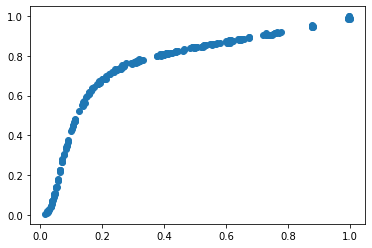

In [3]:
x0 = np.array(df['x0'])
y0 = np.array(df['y0'])
x = x0/np.max(x0)
y = y0/np.max(y0)
plt.plot(x,y, 'o')

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

In [4]:
yn = y + np.random.normal(0, 0.02, y.shape)

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(x,yn,test_size = 0.33)

## Initial Fit for a Rational Model

In [6]:
def predict(w,x):
    
    d = (len(w)-1)//2
    
    a = np.flip(w[:d+1]) 
    b = np.flip(w[d+1:])
    

    yhat = np.polyval(a,x)/(1 + np.polyval(b,x)) 
    return yhat

In [7]:
Xtr = Xtr.reshape(-1,1)
Xts = Xts.reshape(-1,1)
ytr = ytr.reshape(-1,1)
yts = yts.reshape(-1,1)

In [8]:
d = 3

xf = Xtr
for i in range(d-1):
    xf = np.hstack([xf, Xtr**(i+2)])

yf = -np.multiply(ytr, xf)   
Z = np.column_stack([xf, yf])


regr = LinearRegression()
regr.fit(Z,ytr)

winit = np.hstack([np.array([regr.intercept_]), regr.coef_])
winit = np.transpose(winit)

Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

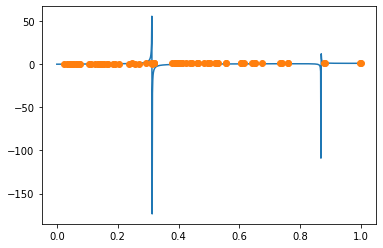

In [9]:
xpred = np.linspace(0,1, num = 1000)
yhat = predict(winit, xpred)
plt.plot(xpred, yhat)
plt.plot(Xts, yts, 'o')

Using Ridge Regression

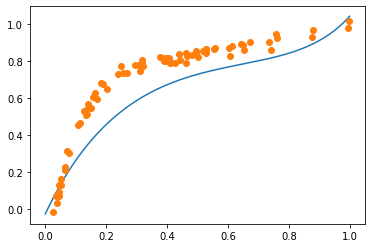

In [10]:
regr = Ridge(alpha=1e-3)
regr.fit(Z, ytr)

winit = np.hstack([np.array([regr.intercept_]), regr.coef_])
winit = np.transpose(winit)

xr = np.linspace(0,1, num = 1000)
yr = predict(winit, xr)
plt.plot(xr, yr)
plt.plot(Xts, yts,'o')
wr = winit

## Creating a Loss Function


In [11]:
def feval(w,x,y):
        
    d = (len(w)-1)//2
    a = w[:d+1] 
    b = w[d+1:]
        
    Znum = np.zeros((Xtr.shape[0], d+1))
    Zden = np.zeros((Xtr.shape[0], d+1))
    
    for i in range(x.shape[0]):
        for j in range(d+1):
            Znum[i,j] = x[i]**j
            Zden[i,j] = x[i]**(j+1)

    
    Zden = np.delete(Zden, d, 1)
    Zdt = np.dot(Zden,b).reshape(-1,1)
    Zdt = np.sum((np.ones((x.shape[0],1)), Zdt),axis=0)
    
    yhat = Znum.dot(a)/(Zdt)
    
    f = 0.5*np.sum((y-yhat)**2) 
    
    temp1 = np.sum((y-yhat), axis = 1)
    temp2 = Znum/(Zdt)
    fgrad_a = -np.dot(temp1, temp2).reshape(-1,1)
        
    temp3 = (yhat*Zden)/Zdt
    fgrad_b = np.dot(temp1, temp3).reshape(-1,1)
    
    fgrad = np.vstack([fgrad_a, fgrad_b])
    
    return f, fgrad

Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [12]:
p = Xtr.shape[1]+1
w0 = wr

step = 1e-6
w1 = w0 + step*np.random.randn(p)
w1 = w1[:,1].reshape(-1,1)
f0, fgrad0 = feval(w0, Xtr, ytr)
f1, fgrad1 = feval(w1, Xtr, ytr)

df_est = np.sum(np.multiply(fgrad0, (w1-w0)))

print("Actual f1-f0    = {}".format((f1-f0)))
print("Predicted f1-f0 = {}".format(df_est))

Actual f1-f0    = 1.0529440980233673e-07
Predicted f1-f0 = 1.0524644641463945e-07


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

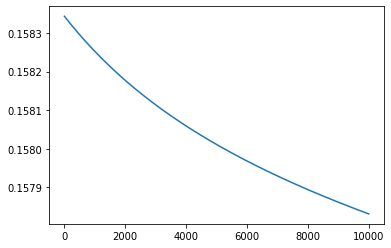

In [13]:
nit = 10000
step = 1e-6
fgd = np.ones(nit)
w0 = wr

for it in range(nit):
    f0, fgrad0 = feval(w0, Xtr, ytr)
    fgd[it] = f0
    w0 = w0 - step*fgrad0

plt.plot(fgd)

Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

Text(0, 0.5, 'Cost')

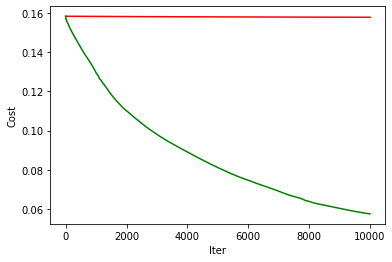

In [14]:
nit = 10000
step = 1e-6  
lr_init = 1e-3
lr_min = 1e-6
beta = 2

w0 = wr
lr = lr_init
cost_ad = np.ones(nit)

f0, fgrad0 =  feval(w0, Xtr, ytr)

for it in range(nit):
    wt = w0 - lr*fgrad0
    f1, fgrad1 = feval(wt, Xtr, ytr)
    df_est = np.sum(np.multiply(fgrad0, (wt-w0)))
    c = 0.6
    
    if (((f1-f0) < c*df_est) and (f1<f0)):
        lr = lr*beta
        f0 = f1
        fgrad0 = fgrad1
        w0 = wt
    else:
        lr = lr/beta
        lr = np.maximum(lr, lr_min)
    cost_ad[it] = f0

plt.plot(fgd, 'r-')
plt.plot(cost_ad, 'g-')
plt.xlabel('Iter')
plt.ylabel('Cost')

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

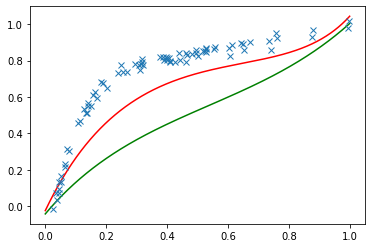

In [15]:
xpred = np.linspace(0,1,num = 1000)
yhat1 = predict(w0, xpred)
plt.plot(xpred, yhat1, 'g-')

yhat2 = predict(winit, xpred)
plt.plot(xpred, yhat2, 'r-')

plt.plot(Xts, yts, 'x')

## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-5`.   Compare the convergence of the loss function with gradient descent.  

In [16]:
nit = 1000
step = 1e-5
beta = 0.99

w0 = winit
cost = np.ones(nit)
Z = np.ones(len(w0))

f0, fgrad0 =  feval(w0, Xtr, ytr)

for it in range(nit):
    f0, fgrad0 = feval(w0,Xtr,ytr)
    Z = beta*Z + (1-beta)*fgrad0
    w0 = w0 - step*fgrad0
    cost[it] = f0    

Text(0, 0.5, 'Cost')

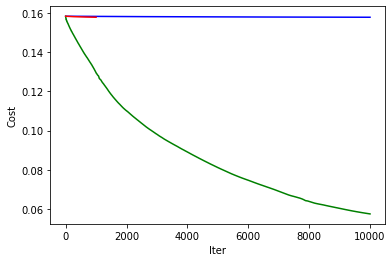

In [17]:
plt.plot(fgd,'b-')

plt.plot(cost_ad,'g-')
plt.plot(cost,'r-')
plt.xlabel("Iter")
plt.ylabel("Cost")